In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [6]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [7]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [8]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [9]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    pa_dmso = p + 'DMSO_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'dmso' in filename:
            
            im=cv2.imread(pa_dmso + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [10]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [11]:
def loadImages_LSTM(path_data,len_t_points):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),len_t_points, 64))

    return x_orig 

In [12]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [13]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [14]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [15]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'control':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
            
        if y[ix][0] == 'dmso':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [16]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test, verbose = 1)
    results.append(scores[1]*100)

    return results

In [17]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, 5))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [18]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_validation/'

In [19]:
mid = ['C6', 'F11']
leb = ['D11', 'G4']
mep = ['F2', 'G10']
met = ['G5', 'B10']
oxy = ['G3', 'B8']

cyc = ['E4', 'G6']
dox = ['G8', 'D10']
olo = ['E7', 'B7']
ket = ['E10', 'B11']
orp = ['D8', 'B2']

In [20]:
tot_results_accuracy = []

results_lstm = []

In [21]:
tot_well_adr = [mid, leb, mep, met, oxy]
tot_well_hrh = [cyc, dox, olo, ket, orp]

string_well_adr = ['mid', 'leb', 'mep', 'met', 'oxy']
string_well_hrh = ['cyc', 'dox', 'olo', 'ket', 'orp']


In [22]:
tot_well = []
string_well = [] 

In [23]:
a = 'HRH' # FOR TEST SET
b = 'CONTROL' # FOR REST

if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [24]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 335.390625 steps, validate for 115.453125 steps
Epoch 1/300
336/335 [==============================] - 15s 43ms/step - loss: 0.6696 - accuracy: 0.6101 - val_loss: 0.6644 - val_accuracy: 0.5900
Epoch 2/300
336/335 [==============================] - 11s 32ms/step - loss: 0.6212 - accuracy: 0.6594 - val_loss: 0.6682 - val_accuracy: 0.5994
Epoch 3/300
336/335 [==============================] - 11s 32ms/step - loss: 0.6029 - accuracy: 0.6751 - val_loss: 0.6671 - val_accuracy: 0.6043
Epoch 4/300
336/335 [==============================] - 10s 31ms/step - loss: 0.5900 - accuracy: 0.6879 - val_loss: 0.6670 - val_accuracy: 0.6081
Epoch 00004: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 335.390625 steps, validate for 115.453125 steps
Epoch 1/300
336/335 [==============================] - 25s 73ms/step - loss: 0.5719 - accuracy: 0.7035 - val_loss: 0.6838 - val_accuracy: 0.5949
Epoch 2/300
336/335 [==========

ValueError: cannot reshape array of size 28160 into shape (22,32,64)

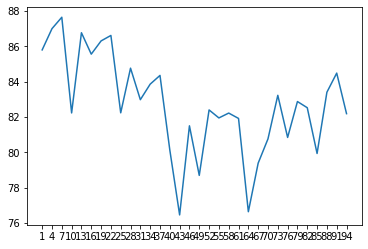

In [25]:
for num_ix, rand_num in enumerate(rand):
    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,97,3)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(a)

        # NAME OF THE WELLS CORRESPONDING TO THE DRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0], tot_well[index_t_well][1]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)

        groups_list = ['{}'.format(a), '{}'.format(b)]

        fileds_of_view = ['1','2','3','4']

        field_train, field_val = train_test_split(fileds_of_view, test_size=0.2, random_state=rand_num)


        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename and '_{}-'.format(wells_drug[1]) not in filename and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        for i in group_compounds:

            for f in field_train:
                if '-{}_'.format(f) in i:
                    train.append(i)


            for v in field_val:
                if '-{}_'.format(v) in i:
                    validation.append(i)


        x_train = loadImages(train)
        y_train = make_labels(train)



        x_val = loadImages(validation)
        y_val = make_labels(validation)



        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

        batch_size = 128

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(Dense(64, activation='relu'))
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(1,activation='sigmoid'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-4)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                         verbose = 1)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                        verbose = 1)

        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/{}_accuracy.png'.format(string_well[index_t_well]))

        tot_results_accuracy.append(r)
        
        for i, layer in enumerate(m4.layers):
            layer._name = 'layer_' + str(i)



        lstm_model = Model(inputs=m4.input, outputs=m4.get_layer('layer_4').output)

        del m4
        K.clear_session()
        
        data_name = [train,test,validation]

        feat_name = ['train', 'test', 'validation']

        for index_name, _ in enumerate(data_name):

            path =  data_name[index_name]

            name_well = []

            for i in path:
                name_well.append(i.split('_id')[0])

            wells = list(set(name_well))
            wells

            for w in wells:

                time = []


                for filename in sorted(path, key = natural_keys):
                    if w in filename: #PAY ATTENTION ID THE IMAGE IS A TIFF OR PNG IMAGE #########
                        time.append(filename)

                data_id = {}
                n_id = []
                w_n = []

                for i in time:
                    t = i.split('_id_')[1].split('time_')[0]
                    f = i.split('_id_')[0].split('time_')[0]
                    n_id.append(t)
                    w_n.append(f)

                id_cell = set(n_id)


                for ix, i in enumerate(sorted(id_cell, key = natural_keys)):

                    id_name = []
                    dict_1 = {}

                    for t in time:
                        if 'id_{}'.format(i) in t:
                            id_name.append(t)

                    d = {'id':id_name}
                    data = pd.DataFrame(d)

                    dict_1[ix]=data 
                    data_id.update(dict_1) 

                delete = [i for i, j in data_id.items() if len(j) != 20] #len(time_points)] # 9 or the length of time span you are traning on 
                for i in delete : del data_id[i]

                len_id = [i for i, j in data_id.items()]

                for le in len_id:    


                    e = pd.DataFrame(data_id[le])

                    coords = e.values.tolist()
                    id_cells = []
                    for i in coords:
                        for j in i:
                            id_cells.append(j)

                    x_orig = loadImages(id_cells)
                    x_orig = resize(x_orig)

                    x_orig = preprocess_input(x_orig)
                    output = lstm_model.predict(x_orig)
                    np.save('/home/jovyan/DATA_MASTER_PROJECT/LSTM//FEAT_FOLDERS/features_{}/features_well_{}_id_{}.npy'.format(feat_name[index_name],w_n[0], le), output)
            print('Saved_feature_{}'.format(feat_name[index_name]))


        x_train_lstm = loadImages_LSTM(train_data, len(time_points))
        y_train_lstm = make_labels_LSTM(y_tra_path)

        x_test_lstm = loadImages_LSTM(tes_data, len(time_points))
        y_test_lstm = make_labels_LSTM(y_tes_path)

        x_val_lstm = loadImages_LSTM(val_data, len(time_points))
        y_val_lstm = make_labels_LSTM(y_val_path)

        weights_lstm = class_weight.compute_class_weight('balanced', np.unique(y_train_lstm),y_train_lstm)


        m = Sequential()
        m.add(LSTM(32, input_shape = (x_train_lstm.shape[1],x_train_lstm.shape[2])))
        m.add(Dropout(0.2))
        m.add(Dense(1, activation='sigmoid'))


        opt_lstm = keras.optimizers.Adam(lr=1e-4)

        m.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m_h = m.fit(x_train_lstm,y_train_lstm,

                         callbacks = [es],

                        epochs=epochs,
                        validation_data = (x_val_lstm,y_val_lstm), 

                        class_weight = weights_lstm)


        scores_lstm = m.evaluate(x_test_lstm, y_test_lstm)
        results_lstm.append([scores_lstm[1]*100, string_well[index_t_well]])
        
        del m
        K.clear_session()

        # DELITE FILES IN FEATURE VECTOR FOLDERS

        folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

        for fo in folders:
            file = glob.glob(f'{fo}/*')
            for f in file:
                os.remove(f)

In [ ]:
# ACCURACY SCORE AVERAGE FOR CNN
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

In [ ]:
cv_s_mean,_ = zip(*cv_s)

m_cv = np.mean(list(cv_s_mean))
m_cv    

In [ ]:
# PLOT OF MEAN ACCURACY FOR EVERY TIME POINT CNN

l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, 5))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.mean(s1, axis=0))

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/cv_score.png')

In [ ]:
me = np.mean(cv_plot, axis = 0)
me = me.flatten()

In [ ]:
sd = np.std(cv_plot, axis = 0)
sd = sd.flatten()

In [ ]:
results_lstm = sorted(results_lstm, key=lambda x: x[1])
r_lstm , _ = zip(*results_lstm)
    
r_lstm = list(r_lstm)

re_lstm = list(np.array_split(r_lstm, 5))

cv_lstm = []

for ix, i in enumerate(re_lstm):
    r1 = list(re_lstm[ix])
    cv_lstm.append(np.mean(r1))


In [ ]:
cv_lstm = list(zip(cv_lstm, string_well))
cv_lstm

In [ ]:
cv_l_mean,_ = zip(*cv_lstm)

m_cv_l = np.mean(list(cv_l_mean))
m_cv_l 

In [ ]:
sd_cv_l =  np.std(list(cv_l_mean))
sd_cv_l

In [ ]:
# BEFORE RUNNING AGAIN

folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

for fo in folders:
    file = glob.glob(f'{fo}/*')
    for f in file:
        os.remove(f)

In [ ]:
plt.rc('ytick', labelsize=18)
ax = plt.figure(figsize=(13,8), facecolor='w').gca()
ax.plot(me)
ax.fill_between(time_points, me - sd, me + sd, alpha = 0.5)

plt.errorbar(10.5, m_cv_l, sd_cv_l, linestyle='None', marker='^', markersize=12)

plt.savefig('/home/jovyan/md_sd_score.png')

In [ ]:
cnn_stat = [i for i in cv_s_mean]
lstm_stat = [i for i in cv_l_mean]

from scipy.stats import wilcoxon

stat, p = wilcoxon(cnn_stat, lstm_stat)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')